# Moment Tensor Decomposition Tool

This workbook is a port of the matlab mtdecomp.m tool for decomposing a moment tensor solution.

Written by Douglas Dreger July 26, 2018

Updated: Dreger September 2, 2020

# Background

### This notebook takes an input moment tensor in Aki & Richard convention and applies a source type decomposition. The moment tensor is decomposed into an isotropic tensor and a deviatoric tensor. The deviatoric tensor is further decomposed to a double-couple and a CLVD that share the same principle eigenvector (either compression or dilation). An excellent description of this is given in Bob Herrmann's 'A Student's Guide to the Moment Tensor' (Jost and Herrmann, 1989). It also plots the moment tensor in the Tape & Tape (2014) source-type Lune, a geometrical representation of the moment tensor. Source-type plots are quite useful for interpreting moment tensor results particularly for atypical seismic events (underground cavity collapse, volcanic/geothermal seismicity, and explosions). The example given is for the DPRK 2017 nuclear test from Chiang et al. (2018).

### Some Good Reading

1. Jost, M. L. and R. B. Herrmann (1989), A student's guide to and review of moment tensors, Seism. Res. Letters, 60, 37-57.
2. Tape, W., and C. Tape, (2012), A geometric setting for moment tensors, Geophys. J. Int., 190(1), 476-498, doi: 10.1111/j.1365-246X.2012.05491.x. 
3. Chiang, A. , D. S. Dreger, S. R. Ford, G. A. Ichinose, E. Matzel, S. Myers, and W. R. Walter (2018). Moment tensor source-type analysis for the Democratic People’s Republic of Korea declared nuclear explosions (2006-2017) and 03-SEP2017 collapse event,Seism. Res. Lett., Vol. 89, No. 6, 2152-2165, doi: 10/1785/0220180130.

### This notebook uses the mopad functions of obspy and a wrapper modified by Andrea Chiang to correctly the full moment tensor.

In [1]:
#Enter moment tensor parameters here
#It is assumed that the moment tensor units are SI, x1.0e13 dyne cm

#DPRK2017 Nuclear Test
Mxx=6630.
Myy=6530.
Mzz=7030.
Mxy=-1030.
Mxz=200.
Myz=500.

#NAPA Earthquake BSL Solution
"""
Mxx=-1.
Mxy=0.
Mxz=0.
Myy=-1.
Myz=0.
Mzz=-1.
"""



moscale=1.0e13                                                   #scale value for moment estimates and Mw
                                                                 #note if applied to tensors and passed to 
                                                                 #mopad the very large values leads to plotting errors can result

In [2]:
#Initialization of packages
import math
import numpy as np
from numpy import linalg as la
import matplotlib
import matplotlib.pyplot as plt

#Note that Andrea Chiang's modified mopad.py and mopad_wrapper.py need to be in the same directory as the notebook
import sys                 
sys.path.append('./')
from mopad_wrapper import beach
import fpsol

In [3]:
Mfull=np.array([[Mxx,Mxy,Mxz],[Mxy,Myy,Myz],[Mxz,Myz,Mzz]])  #Construct Moment Tensor Matrix
L, V = la.eig(Mfull)

if L[0]==L[1] and L[0]==L[2]:
    print('Pure Isotropic')                                         #deal with this perfect isotropic case
    Mxx=Mxx+Mxx*0.0001
    Mfull[0,]=Mfull[0,]+Mfull[0,]*0.0001

Moiso=(Mxx+Myy+Mzz)/3                                                #Esimate the Scalar Moment

Mdev=Mfull - np.identity(3)*Moiso                                    #Compute the Deviatoric Moment Tensor

w, v = la.eig(Mdev)                                                  #Calculate eigenvalues(w) and eigenvectors(v)

Motot=(abs(Moiso) + max(abs(w)))*moscale                             #Compute Bower and Hudson Total Moment and the 
Mw=(np.log10(Motot)-9.1)/1.5                                         #Moment Magnitude

Moiso=Moiso*moscale                                                  #Now scale Moiso and Modev for plotting later
Modev=max(abs(w))*moscale                                            #Modev is maximum deviatoric eigenvalue in absolute sense
                                                                     #It is used to scale deviatoric tensor into DC and CLVD components


#Order the eigenvalues and eigenvectors
indx=np.argsort(abs(w))                                              #Sort by absolute value of w
m3=w[indx[2]]                                                        
m2=w[indx[1]]
m1=w[indx[0]]
eig3=v[:,indx[2]]
eig2=v[:,indx[1]]
eig1=v[:,indx[0]]

#Order eigenvalues for Tape & Tape Lune
indx=np.argsort(L)                                                  #Sort retaining sign
l1=L[indx[2]]
l2=L[indx[1]]
l3=L[indx[0]]

#Calculate Tape & Tape gamma and beta parameters testing for pure isotropic singularity
#These parameters, gamma, beta and delta are used later to plot the source-type in the Tape and Tape Lune perspective
if l1 == l2 and l1 == l3 and l1 > 0.:
    gamma=0.
    beta=0.
    delta=90. - beta
elif l1 == l2 and l1 == l3 and l1 < 0.:
    gamma=0.
    beta=0.
    delta=beta - 90.
else:
    gamma=math.atan((-l1+2*l2-l3)/(np.sqrt(3)*(l1-l3)))*180/math.pi
    beta=math.acos((l1+l2+l3)/(np.sqrt(3)*np.sqrt(L.dot(L))))*180/math.pi
    delta=90. - beta
    
#Construct Dyadics
#Dyadics represent fundamental vector-dipole tensors from which double-couples, CLVDs, tensile-cracks, etc. are constructed
#See Jost and Herrman for details
a3=np.array((eig3, eig3, eig3)).transpose()
a2=np.array((eig2, eig2, eig2)).transpose()
a1=np.array((eig1, eig1, eig1)).transpose()
a3a3=a3*a3.transpose()
a2a2=a2*a2.transpose()
a1a1=a1*a1.transpose()

#Perform DC-CLVD Decomposition
F=-1*m1/m3
Mdc=m3*(1-2*F)*(a3a3-a2a2)                                  #Double-Couple Moment Tensor
Mclvd=m3*F*(2*a3a3-a2a2-a1a1)                               #CLVD Moment Tensor
Modc=abs(m3*(1-2*F))*moscale                                #Double-Couple Moment
Moclvd=abs(2*m3*F)*moscale                                  #CLVD Moment - to be consistent with Hudson decomp
kappa=Moiso/Motot                                           #Hudson Plot kappa
T=(2*m1)/abs(m3)                                            #Hudson Plot T
periso=abs(Moiso/Motot)
perdc=abs(Modc/Modev)
perclvd=abs(Moclvd/Modev)

#Determine Strike, Rake, Dip
if Modc != 0.:
    w, v = la.eig(Mdc)
    indx=np.argsort(w)                                              #Sort by absolute value of w
    eig3=v[:,indx[2]]
    eig2=v[:,indx[1]]
    eig1=v[:,indx[0]]
    nu1=(1/np.sqrt(2))*(eig3-eig1)   #fault normal vector
    u1=(1/np.sqrt(2))*(eig1+eig3)    #slip vector
    [strike1, rake1, dip1]=fpsol.fpsol(nu1,u1)
    nu2=(1/np.sqrt(2))*(eig1+eig3)   #conjugate fault normal vector
    u2=(1/np.sqrt(2))*(eig3-eig1)    #conjugate slip vector
    [strike2, rake2, dip2]=fpsol.fpsol(nu2,u2)

#Construct Moment Tensor arrays for plotting
fm=np.array((Mxx,Myy,Mzz,Mxy,Mxz,Myz))
devm=np.array((Mdev[0,0], Mdev[1,1], Mdev[2,2], Mdev[0,1], Mdev[0,2], Mdev[1,2]))
dcm=np.array((Mdc[0,0], Mdc[1,1], Mdc[2,2], Mdc[0,1], Mdc[0,2], Mdc[1,2]))
clvdm=np.array((Mclvd[0,0], Mclvd[1,1], Mclvd[2,2], Mclvd[0,1], Mclvd[0,2], Mclvd[1,2]))



In [4]:
print(f'Mw={Mw:.2f} Motot={Motot:.2e} Moiso={Moiso:.2e}  Modev={Modev:.2e}')
print(f'PerIso={periso*100:.1f} PerDC={perdc*(1-periso)*100:.1f}({perdc*100:.1f}) PerCLVD={perclvd*(1-periso)*100:.1f}({perclvd*100:.1f}) Values in () are deviatoric percentages')
if Modc != 0.:
    print(f'DC Moment={Modc:.3e}')
    print(f'Strike   Rake   Dip')
    print(f'{strike1:3.1f}    {rake1:3.1f}   {dip1:3.1f}')
    print(f'{strike2:3.1f}    {rake2:3.1f}   {dip2:3.1f}')

Mw=5.20 Motot=8.07e+16 Moiso=6.73e+16  Modev=1.34e+16
PerIso=83.4 PerDC=7.1(43.1) PerCLVD=9.4(56.9) Values in () are deviatoric percentages
DC Moment=5.753e+15
Strike   Rake   Dip
270.3    2.4   63.0
179.2    153.0   87.9


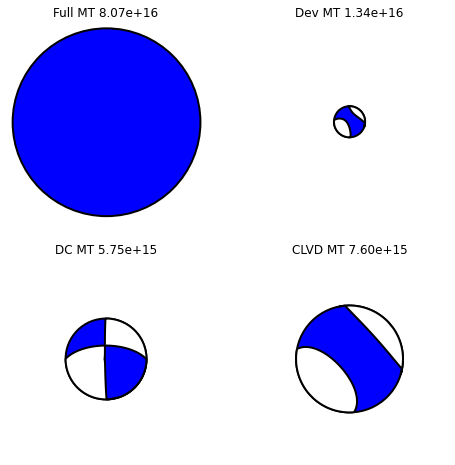

In [5]:
#Make Plots

#Scaled by total moment
# First one plots the full mt
# The conditional statements were added because mopad returns an error for identially zero-valued moment tensors
# i.e. pure double-couple solution would have a zero-valued clvd moment tensor
fig=plt.figure(figsize=(8,8))
threshold=0.;                    #initialize threshold
if Moiso != 0.0:
    beach1 = beach(fm,xy=(0.5,0.5),width=0.95,mopad_basis='NED',show_iso=True)
    ax2 = fig.add_subplot(2,2,1)
    ax2.add_collection(beach1)
    ax2.set_aspect("equal")
    ax2.set_axis_off()
    buf="Full MT {0:.2e}".format(Motot)
    ax2.set(title=buf)
    threshold=Moiso*0.00001  #Set Modev threshold to a small value of Mosio if there is a Moiso

# Second one plots deviatoric mt
if Modev != 0.0 and Modev/Motot > 0.001:   #plot only significant deviatoric parts
    beach1 = beach(devm,xy=(0.5,0.5),width=0.95*Modev/Motot,mopad_basis='NED')
    ax3 = fig.add_subplot(2,2,2)
    ax3.add_collection(beach1)
    ax3.set_aspect("equal")
    ax3.set_axis_off()
    buf="Dev MT {0:.2e}".format(Modev)
    ax3.set(title=buf)

# Third one plots dc
if Modc != 0.0 and Modc/Motot > 0.001:     #plot only significant double-couple parts
    beach1 = beach(dcm,xy=(0.5,0.5),width=0.95*Modc/Modev,mopad_basis='NED')
    ax3 = fig.add_subplot(2,2,3)
    ax3.add_collection(beach1)
    ax3.set_aspect("equal")
    ax3.set_axis_off()
    buf="DC MT {0:.2e}".format(Modc)
    ax3.set(title=buf)

# Forth one plots dc
if Moclvd != 0.0 and Moclvd/Motot > 0.001:  #plot only signicant clvd parts
    beach1 = beach(clvdm,xy=(0.5,0.5),width=0.95*Moclvd/Modev,mopad_basis='NED')
    ax3 = fig.add_subplot(2,2,4)
    ax3.add_collection(beach1)
    ax3.set_aspect("equal")
    ax3.set_axis_off()
    buf="CLVD MT {0:.2e}".format(Moclvd)
    ax3.set(title=buf)

#f.savefig("mtdecomp_mt_plt.png")
fig.savefig("mtdecomp_mt_plt.png")
plt.show()

In [8]:
#Read the NSS output and compute Tape and Tape parameters for plotting
import pandas as pd
#data=pd.read_csv('nss_v30_combined.txt', sep='\s+', header=None)
data=pd.read_csv('chiang_etal_2018_dprk_nss_mtfm.txt', sep='\s+', header=None)
d=np.array(data)
lam=np.array((d[:,0],d[:,1],d[:,2])).transpose()   #eigenvalues are column ordered each row is a individual tuple
lam.sort(axis=1)   #sort eigenvalue rows lam1=d[:,2], lam2=d[:,1], lam3=d[:,0]
vr=d[:,3]

l1=lam[:,2]
l2=lam[:,1]
l3=lam[:,0]
L=np.sqrt(l1**2 + l2**2 + l3**2)

#Test for pure isotropic singularity and compute gamma, beta and delta
n=len(l1)
GAMMA=np.zeros(n)
BETA=np.zeros(n)
DELTA=np.zeros(n)
for i in range(0,n,1):                       
    if l1[i] == l2[i] and l1[i] == l3[i] and l1[i] > 0.:
        GAMMA[i]=0.
        BETA[i]=0.
        DELTA[i]=90. - BETA[i]
    elif l1[i] == l2[i] and l1[i] == l3[i] and l1[i] < 0.:
        GAMMA[i]=0.
        BETA[i]=0.
        DELTA[i]=BETA[i] - 90.
    else:
        GAMMA[i]=np.arctan((-l1[i]+2*l2[i]-l3[i])/(np.sqrt(3)*(l1[i]-l3[i])))*180/np.pi
        BETA[i]=np.arccos((l1[i]+l2[i]+l3[i])/(np.sqrt(3)*L[i]))*180/np.pi
        DELTA[i]=90. - BETA[i]
    

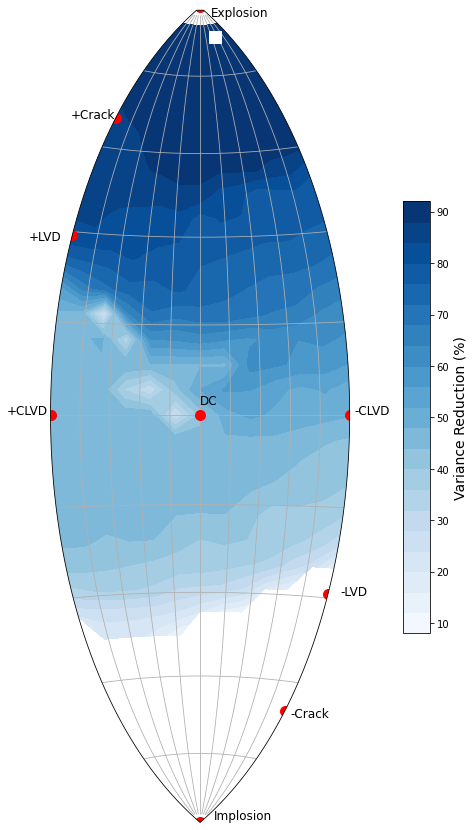

In [89]:
#Plot Tape and Tape Lune
#Initial code from 'Ajean' https://stackoverflow.com/questions/32209496/matplotlib-basemap-fundamental-lune

import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.path as mpath
from scipy.interpolate import griddata

# Mollweide projection
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection=ccrs.LambertAzimuthalEqualArea())  #This seems best
ax.set_extent([-30, 30, -90, 90])
xstep=30/5 #20% lines
ystep=90/5 #20% lines
xgrds=np.arange(-30.0, 31.0, xstep)
ygrds=np.arange(-90.0, 91.0, ystep)
ax.gridlines(xlocs=xgrds,ylocs=ygrds)

# Here I define a matplotlib Path object to use as the boundary
outlinex = np.concatenate([[-30],np.tile(-30,180), np.tile(30,180),[-30]])
outliney = np.concatenate([[-90],np.arange(-90,90),np.arange(89,-91,-1),[-90]])
outlinecodes = np.array([mpath.Path.MOVETO]+[mpath.Path.LINETO]*360+[mpath.Path.MOVETO])
outlinepath = mpath.Path(np.column_stack([outlinex[::-1], outliney[::-1]]), outlinecodes[::-1])
ax.set_boundary(outlinepath, transform=ccrs.Geodetic())



#Fundamental Source-Types
ax.plot(0, 90., 'ro', markersize=10, transform=ccrs.Geodetic())  #Explosion
ax.text(30,87,'Explosion',fontsize=12,transform=ccrs.Geodetic())
ax.plot(0, -90., 'ro', markersize=10, transform=ccrs.Geodetic())  #Implosion
ax.text(70,-88,'Implosion',fontsize=12,transform=ccrs.Geodetic())
ax.plot(0, 0, 'ro', markersize=10, transform=ccrs.Geodetic())   #Double-Couple
ax.text(0,2,'DC',fontsize=12,transform=ccrs.Geodetic())
ax.plot(30, 0, 'ro', markersize=10, transform=ccrs.Geodetic())  #Negative CLVD
ax.text(31,0,'-CLVD',fontsize=12,transform=ccrs.Geodetic())
ax.plot(-30, 0, 'ro', markersize=10, transform=ccrs.Geodetic()) #Positive CLVD
ax.text(-39,0,'+CLVD',fontsize=12,transform=ccrs.Geodetic())
LAM=np.array([3,1,1])
x=math.atan((-LAM[0]+2*LAM[1]-LAM[2])/(np.sqrt(3)*(LAM[0]-LAM[2])))*180/math.pi
y=math.acos((LAM[0]+LAM[1]+LAM[2])/(np.sqrt(3)*np.sqrt(LAM.dot(LAM))))*180/math.pi
y=90. - y
ax.plot(x, y, 'ro', markersize=10, transform=ccrs.Geodetic())  #Tensile Crack
ax.text(x-15,y-2,'+Crack',fontsize=12,transform=ccrs.Geodetic())
LAM=np.array([-1,-1, -3]) #note ordering is due to sign considered ordering
x=math.atan((-LAM[0]+2*LAM[1]-LAM[2])/(np.sqrt(3)*(LAM[0]-LAM[2])))*180/math.pi
y=math.acos((LAM[0]+LAM[1]+LAM[2])/(np.sqrt(3)*np.sqrt(LAM.dot(LAM))))*180/math.pi
y=90. - y
ax.plot(x, y, 'ro', markersize=10, transform=ccrs.Geodetic())  #Closing Crack
ax.text(x+3,y-1,'-Crack',fontsize=12,transform=ccrs.Geodetic())
LAM=np.array([1,0,0])
x=math.atan((-LAM[0]+2*LAM[1]-LAM[2])/(np.sqrt(3)*(LAM[0]-LAM[2])))*180/math.pi
y=math.acos((LAM[0]+LAM[1]+LAM[2])/(np.sqrt(3)*np.sqrt(LAM.dot(LAM))))*180/math.pi
y=90. - y
ax.plot(x, y, 'ro', markersize=10, transform=ccrs.Geodetic())  #LVD
ax.text(x-10,y-2,'+LVD',fontsize=12,transform=ccrs.Geodetic())
LAM=np.array([0,0,-1])
x=math.atan((-LAM[0]+2*LAM[1]-LAM[2])/(np.sqrt(3)*(LAM[0]-LAM[2])))*180/math.pi
y=math.acos((LAM[0]+LAM[1]+LAM[2])/(np.sqrt(3)*np.sqrt(LAM.dot(LAM))))*180/math.pi
y=90. - y
ax.plot(x, y, 'ro', markersize=10, transform=ccrs.Geodetic())  #LVD
ax.text(x+3,y-0,'-LVD',fontsize=12,transform=ccrs.Geodetic())



# Plot some data
c = plt.cm.plasma(np.arange(0.,100.,10.)/100)
x=np.arange(-30.,31,5)  #The third argument, the step controls smoothing
y=np.arange(-90,90,5)
X, Y= np.meshgrid(x, y)
idx=np.nonzero(vr >= 10.)
Z = griddata((GAMMA[idx],DELTA[idx]),vr[idx],(X,Y), method='cubic')
cb=ax.contourf(X, Y, Z, 20, transform=ccrs.PlateCarree(),cmap='Blues')
ax.plot(gamma, delta, 'ws', markersize=12, transform=ccrs.Geodetic())

# Add colorbar, make sure to specify tick locations to match desired ticklabels
#ax.set_title('Source-Type Lune')
position=fig.add_axes([0.70,0.3,0.025,0.4])  ## the parameters are the specified position you set
cbar=plt.colorbar(cb, cax=position, orientation='vertical',ticks=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], spacing='uniform',shrink=0.5)
cbar.set_label('Variance Reduction (%)', rotation=90, size=14)

fig.savefig("mtdecomp_lune_plt.png")
fig.savefig("mtdecomp_lune_plt.png")
plt.show()